In [1]:
# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

In [2]:
import torch
print(torch.__version__)
print("CUDA disponível:", torch.cuda.is_available())

2.9.0+cu130
CUDA disponível: True


In [3]:
CSV_PATH = r"C:\Users\joaov_zm1q2wh\python\icassp_challenge\joao\data\features_praat_dataset.csv"
df = pd.read_csv(CSV_PATH)

In [4]:
X = df.drop(columns=['ID', 'Age', 'Sex', 'Class']).values

# Normalizar (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dataset e DataLoader
class VoiceFeatureDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class Autoencoder(nn.Module):
    def __init__(self, input_dim=8, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.ReLU(),
            nn.Linear(4, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

dataset = VoiceFeatureDataset(X_scaled)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim=8, latent_dim=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
losses = []
pseudo_accs = []

for epoch in range(n_epochs):
    total_loss = 0
    total_acc = 0
    for features in dataloader:
        features = features.to(device)

        optimizer.zero_grad()
        recon, z = model(features)
        loss = criterion(recon, features)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Pseudo-accuracy baseado no MSE (features normalizadas)
        batch_acc = 1 - torch.mean((recon - features)**2).item()
        total_acc += batch_acc

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    losses.append(avg_loss)
    pseudo_accs.append(avg_acc)
    
    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {avg_loss:.6f}  | Accuracy: {avg_acc:.4f}")

Epoch 1/100 | Loss: 1.051248  | Accuracy: -0.0512
Epoch 2/100 | Loss: 1.029447  | Accuracy: -0.0294
Epoch 3/100 | Loss: 1.009350  | Accuracy: -0.0094
Epoch 4/100 | Loss: 0.988628  | Accuracy: 0.0114
Epoch 5/100 | Loss: 0.966292  | Accuracy: 0.0337
Epoch 6/100 | Loss: 0.942194  | Accuracy: 0.0578
Epoch 7/100 | Loss: 0.918906  | Accuracy: 0.0811
Epoch 8/100 | Loss: 0.888134  | Accuracy: 0.1119
Epoch 9/100 | Loss: 0.859439  | Accuracy: 0.1406
Epoch 10/100 | Loss: 0.829087  | Accuracy: 0.1709
Epoch 11/100 | Loss: 0.798133  | Accuracy: 0.2019
Epoch 12/100 | Loss: 0.767064  | Accuracy: 0.2329
Epoch 13/100 | Loss: 0.738651  | Accuracy: 0.2613
Epoch 14/100 | Loss: 0.709213  | Accuracy: 0.2908
Epoch 15/100 | Loss: 0.685342  | Accuracy: 0.3147
Epoch 16/100 | Loss: 0.663370  | Accuracy: 0.3366
Epoch 17/100 | Loss: 0.643611  | Accuracy: 0.3564
Epoch 18/100 | Loss: 0.625238  | Accuracy: 0.3748
Epoch 19/100 | Loss: 0.610205  | Accuracy: 0.3898
Epoch 20/100 | Loss: 0.593865  | Accuracy: 0.4061
Epoch 

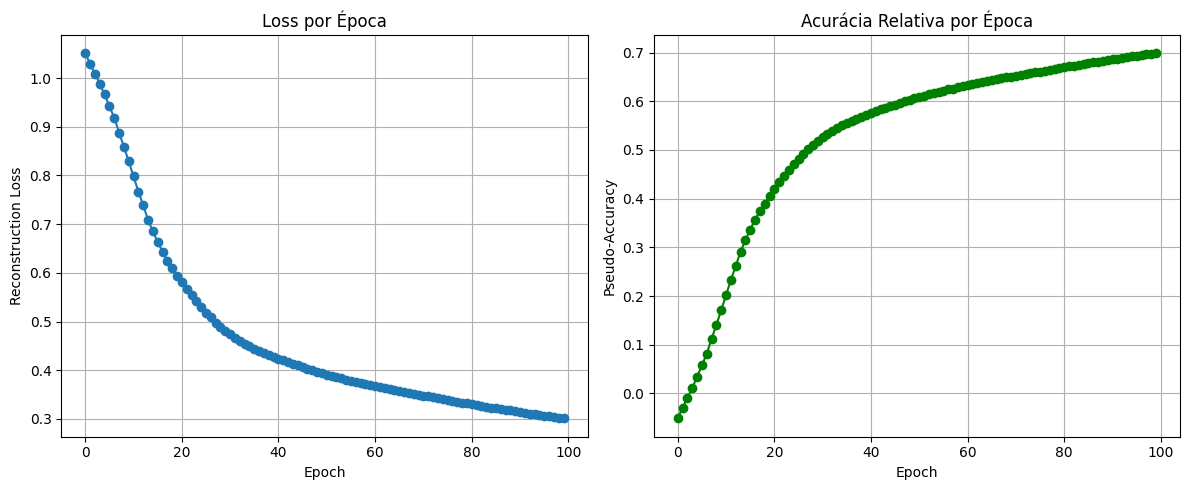

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Loss por Época")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(pseudo_accs, marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Pseudo-Accuracy")
plt.title("Acurácia Relativa por Época")
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
model.eval()
embeddings = []
with torch.no_grad():
    for i in range(len(dataset)):
        x = dataset[i].unsqueeze(0).to(device)
        _, z = model(x)
        embeddings.append(z.cpu().numpy().flatten())

embeddings_df = pd.DataFrame(embeddings, columns=['z1', 'z2', 'z3'])
result = pd.concat([df[['ID', 'Age', 'Sex', 'Class']], embeddings_df], axis=1)
result.to_csv(r"C:\Users\joaov_zm1q2wh\python\icassp_challenge\joao\data\voice_embeddings.csv", index=False)
print(result.head())

      ID  Age Sex  Class        z1        z2        z3
0  ID088   55   F      2  0.066176 -0.116632  0.441552
1  ID105   62   M      3 -1.017118  1.719023  0.283023
2  ID110   55   M      4 -0.691858  1.718075  0.255384
3  ID013   69   F      5 -0.329973  0.369182  0.217432
4  ID006   73   M      5 -1.812901  2.230111  0.191877


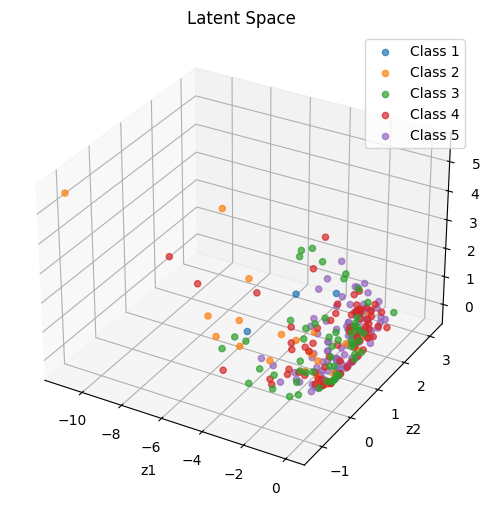

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

classes = sorted(result['Class'].unique())
colors = plt.cm.tab10.colors

for i, cls in enumerate(classes):
    subset = result[result['Class'] == cls]
    ax.scatter(subset['z1'], subset['z2'], subset['z3'], 
    label=f"Class {cls}", alpha=0.7, color=colors[i % len(colors)])

ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
ax.set_title("Latent Space")
ax.legend()
plt.show()

O objetivo principal de analisar o espaço latente é ver se o modelo aprendeu a representar classes diferentes em regiões distintas. 

<b>Separação entre classes</b>

Como podem ver, as cores estão misturadas, o que indica que o espaço latente não está separando bem as classes. Isso sugere que o modelo ainda não capturou bem as características discriminativas entre as classes.

<b>Distribuição e estrutura dos dados</b>

A maior concentração dos pontos está perto da origem (em torno de (0,0) até (-2, 2)), o que é comum em autoencoders, pois o modelo tende a comprimir as representações para regiões centrais.
Há alguns pontos fora desse núcleo, que provavelmente são os outliers ou amostras com características incomuns no conjunto. Esses pontos isolados às vezes revelam anomalias ou exemplos mal reconstruídos.

<b>Densidade e sobreposição</b>

A sobreposição de classes mostra que o modelo pode estar aprendendo características gerais, mas não específicas por classe ou que as classes não são facilmente separáveis nos dados originais.

Temos duas hipóteses para isso:

1. As classes realmente compartilham características semelhantes (pouca separabilidade nos dados brutos);

2. O modelo tem capacidade insuficiente ou regularização excessiva, impedindo-o de criar fronteiras latentes mais distintas.